## Capstone Project - Preserving Heritage: Enhancing Tourism with AI

**Problem Statement**

There are centuries old historical structures that preserve a country's and community's 
history for future generations and promote tourism opportunities. 

To improve tourism, a government agency decides to use advanced machine learning 
techniques to monitor the condition of these historical structures and report if any of 
them need maintenance. 

Also, understanding customers (tourists) and their expectations is critical for effective 
marketing and promotion of tourism. A recommendation engine is an excellent way to 
supplement existing marketing outreach. 

## Part 1

XYZ Pvt. Ltd., a leading industry consulting firm, has been hired to help the cause by 
developing an intelligent and automated AI model using TensorFlow that can predict the 
category of a structure in an image. 

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.19.0'

In [3]:
# Check if TensorFlow can access the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

# List all available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

No GPUs available.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16292516536813227743
xla_global_id: -1
]


### 1.1 Load images

In [5]:
import os

# Use relative paths based on the notebook's location
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from 'notebooks'
data_dir = os.path.join(base_dir, "data", "Part 1")

train_images_path = os.path.join(data_dir, "Stuctures_Dataset")
test_images_path = os.path.join(data_dir, "Dataset_test")

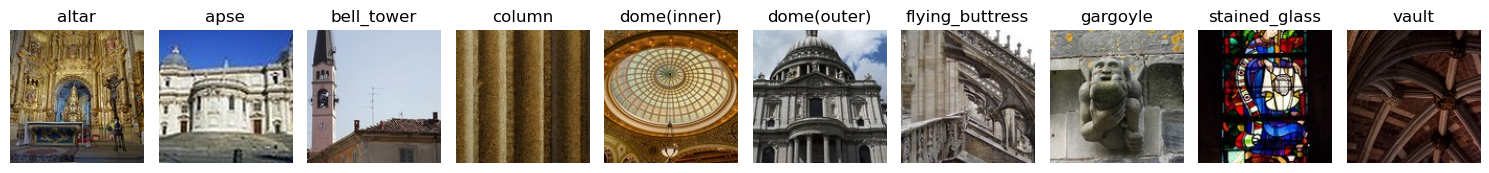

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# List all subfolders (categories)
categories = [d for d in os.listdir(train_images_path) if os.path.isdir(os.path.join(train_images_path, d))]

plt.figure(figsize=(15, 15))
for idx, category in enumerate(categories):
    category_path = os.path.join(train_images_path, category)
    # List all image files in the subfolder
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        img_path = os.path.join(category_path, images[0])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(categories), idx + 1)
        plt.imshow(img_rgb)
        plt.title(category)
        plt.axis('off')
plt.tight_layout()

In [26]:
# Script to remove corrupted images
# This script will check each image in the dataset and remove any that are corrupted.
import os
from PIL import Image

def remove_corrupted_images(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()  # Verify that it is, in fact, an image
                except Exception as e:
                    print(f"Removing corrupted image: {path}")
                    os.remove(path)

remove_corrupted_images(train_images_path)
remove_corrupted_images(test_images_path)

In [27]:
# Allow loading of truncated images in PIL
# This is useful if some images are partially corrupted but still contain some valid data.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

### 1.2 Select Transfer learning model

##### Callbacks

In [21]:
# Early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [22]:
# Accuracy callback to monitor training progress

class MyEarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.90):
        super(MyEarlyStoppingCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')
        if current_val_accuracy is None:
            print(f"\nWarning: 'val_accuracy' not found in logs for epoch {epoch+1}. Callback may not function as expected.")
            print(f"Available logs: {logs.keys()}")
            return
        
        print(f"\nEpoch {epoch+1}: Current Validation Accuracy = {current_val_accuracy:.4f}")
        if current_val_accuracy >= self.target_accuracy:
            print(f"\nTarget Validation Accuracy of {self.target_accuracy:.4f} reached at epoch {epoch+1}.")
            print("Training stopped.")
            self.model.stop_training = True

In [23]:
#L learninrg rate scheduler to adjust the learning rate during training
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch > 5:
        return lr * tf.math.exp(-0.1)
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

In [24]:
# Define the desired accuracy threshold for early stopping
desired_accuracy_threshold = 0.90 
my_stopper = MyEarlyStoppingCallback(target_accuracy=desired_accuracy_threshold)

# Combine the callbacks
callbacks = [early_stop, my_stopper, lr_scheduler]

##### VGG16

In [42]:
# Image genrator for training data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image generator for test data
# Using VGG16 preprocessing function for both training and test data
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [43]:
# Pass images to the generator
train_generator = train_datagen.flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 10235 images belonging to 10 classes.
Found 1475 images belonging to 10 classes.


In [44]:
# VGG16 model
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False 

# Create a new model with the VGG16 base and custom top layers
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = vgg_model(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


In [45]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,694,154 (105.64 MB)

 Trainable params: 12,979,466 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
# Compile the model
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [47]:
# Fit the model

hystory = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=3, #working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks)

Epoch 1/3
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8253 - loss: 5.1614
Epoch 1: Current Validation Accuracy = 0.8560
639/639 ━━━━━━━━━━━━━━━━━━━━ 1707s 3s/step - accuracy: 0.8254 - loss: 5.1572 - val_accuracy: 0.8560 - val_loss: 1.3350 - learning_rate: 0.0010
Epoch 2/3
  1/639 ━━━━━━━━━━━━━━━━━━━━ 22:33 2s/step - accuracy: 0.8750 - loss: 0.2410
Epoch 2: Current Validation Accuracy = 0.8533
639/639 ━━━━━━━━━━━━━━━━━━━━ 186s 288ms/step - accuracy: 0.8750 - loss: 0.2410 - val_accuracy: 0.8533 - val_loss: 1.4643 - learning_rate: 0.0010
Epoch 3/3
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9512 - loss: 0.4432
Epoch 3: Current Validation Accuracy = 0.8770
639/639 ━━━━━━━━━━━━━━━━━━━━ 1565s 2s/step - accuracy: 0.9512 - loss: 0.4432 - val_accuracy: 0.8770 - val_loss: 1.9028 - learning_rate: 0.0010


##### ResNet50

In [31]:
# Images preprocessing generator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
trainImageData_rn50 = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

testImageData_rn50 = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 10235 images belonging to 10 classes.
Found 1475 images belonging to 10 classes.


In [32]:
# Reuse ResNet50 architecture
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False
    
# Create a new model with the ResNet50 base and custom top layers   
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = resnet_model(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model_resnet = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [33]:
model_resnet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,102,346 (286.49 MB)

 Trainable params: 51,514,634 (196.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [34]:
# Compile the model
model_resnet.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [35]:
# Fit the model
history_restnet = model_resnet.fit(
    trainImageData_rn50,
    steps_per_epoch=trainImageData_rn50.samples // trainImageData_rn50.batch_size,
    validation_data=testImageData_rn50,
    validation_steps=testImageData_rn50.samples // testImageData_rn50.batch_size,
    epochs=3,  # working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

Epoch 1/3


c:\Users\filom\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8315 - loss: 3.5122
Epoch 1: Current Validation Accuracy = 0.8458
639/639 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.8316 - loss: 3.5092 - val_accuracy: 0.8458 - val_loss: 1.6049 - learning_rate: 0.0010
Epoch 2/3
  1/639 ━━━━━━━━━━━━━━━━━━━━ 9:46 919ms/step - accuracy: 1.0000 - loss: 0.0050

c:\Users\filom\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: Current Validation Accuracy = 0.8465
639/639 ━━━━━━━━━━━━━━━━━━━━ 57s 88ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.8465 - val_loss: 1.5875 - learning_rate: 0.0010
Epoch 3/3
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.9560 - loss: 0.3089
Epoch 3: Current Validation Accuracy = 0.8607
639/639 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.9560 - loss: 0.3089 - val_accuracy: 0.8607 - val_loss: 1.3528 - learning_rate: 0.0010


##### InceptionV3

In [36]:
# Images preprocessing generator for InceptionV3

trainImageData_inception = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    train_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
)

testImageData_inception = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(
    test_images_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 10235 images belonging to 10 classes.
Found 1475 images belonging to 10 classes.


In [37]:
# Reuse InceptionV3 architecture
model_inception = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers of the InceptionV3 model
for layer in model_inception.layers:
    layer.trainable = False 


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [38]:
# Create a new model with the InceptionV3 base and custom top layers
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = model_inception(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(categories), activation='softmax')(x)

# Create the final model
model_inception_final = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [39]:
# Summary of the model
model_inception_final.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,151,594 (183.68 MB)

 Trainable params: 26,348,810 (100.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [40]:
# Compile the model
model_inception_final.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [41]:
# Fit the model
hystory_inception = model_inception_final.fit(
    trainImageData_inception,
    steps_per_epoch=trainImageData_inception.samples // trainImageData_inception.batch_size,
    validation_data=testImageData_inception,
    validation_steps=testImageData_inception.samples // testImageData_inception.batch_size,
    epochs=3,  # working on CPU, so using 3 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

Epoch 1/3
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7709 - loss: 3.6803
Epoch 1: Current Validation Accuracy = 0.8845
639/639 ━━━━━━━━━━━━━━━━━━━━ 381s 580ms/step - accuracy: 0.7711 - loss: 3.6765 - val_accuracy: 0.8845 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 2/3
  1/639 ━━━━━━━━━━━━━━━━━━━━ 6:03 570ms/step - accuracy: 0.8125 - loss: 0.6582
Epoch 2: Current Validation Accuracy = 0.8859
639/639 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.8125 - loss: 0.6582 - val_accuracy: 0.8859 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 3/3
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9251 - loss: 0.2448
Epoch 3: Current Validation Accuracy = 0.8689
639/639 ━━━━━━━━━━━━━━━━━━━━ 367s 574ms/step - accuracy: 0.9251 - loss: 0.2448 - val_accuracy: 0.8689 - val_loss: 0.5695 - learning_rate: 0.0010


##### Compare the Models

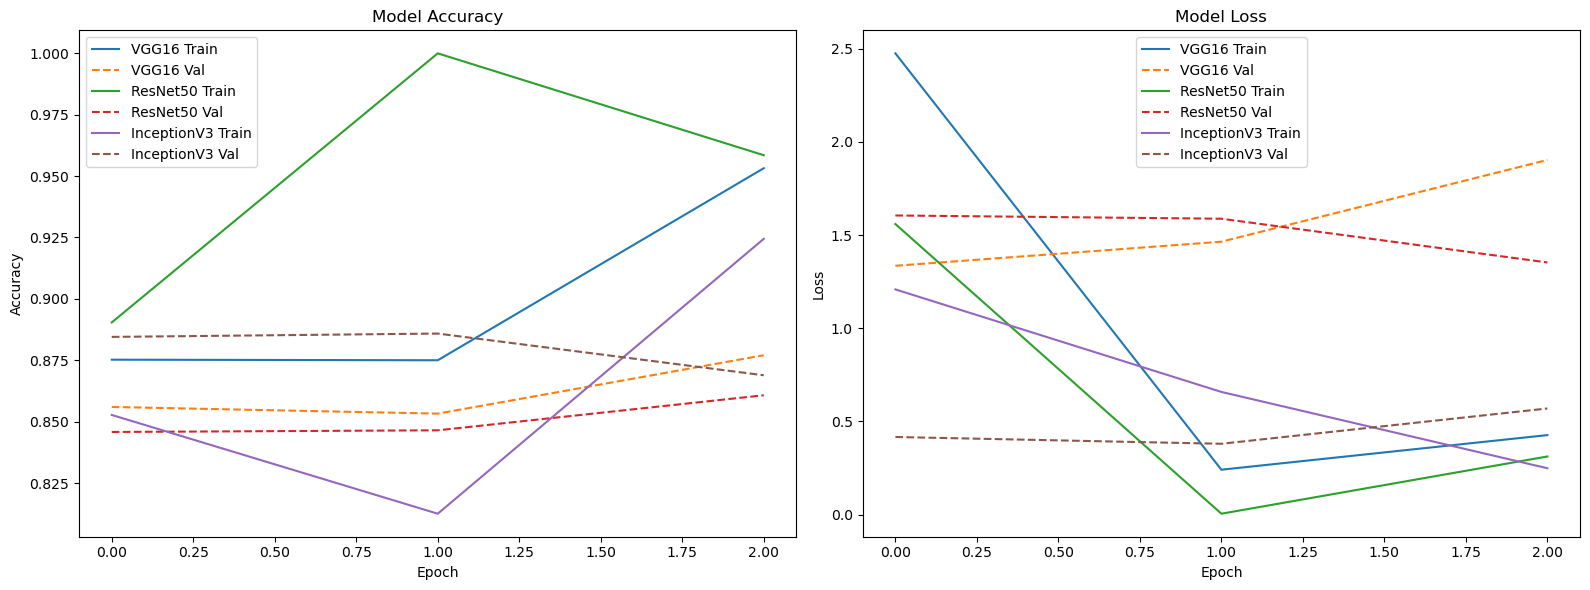

In [48]:
# Compare results/performances of different Transfer Learning models

import matplotlib.pyplot as plt

def plot_history(histories, model_names):
    """
    Plots training and validation accuracy and loss for multiple models.
    Args:
        histories: List of Keras History objects.
        model_names: List of model names as strings.
    """
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history([hystory, history_restnet, hystory_inception], ['VGG16', 'ResNet50', 'InceptionV3'])

All models are overfitted; however, despite VGG16 and RestNet50 increasing in accuracy throughout epochs, Inception V3 decreases in accuracy.
If we look at the loss, only RestNet50 has a decreasing loss.

For these reasons, I will choose RestNet50 as the model.

### 1.3 Fine-tuning the chosen model - RestNet50

In [52]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

x = resnet_model.output # Using ResNet50 as the final model for deployment

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Adding dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding dropout for regularization

output_layer = Dense(len(categories), activation='softmax')(x)

# Create the final model
final_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=output_layer)

# Model summary
final_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,344,586 (100.50 MB)

 Trainable params: 2,756,874 (10.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [53]:
# Compile the model
final_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Fit the final model
final_history = final_model.fit(
    trainImageData_rn50,
    steps_per_epoch=trainImageData_rn50.samples // trainImageData_rn50.batch_size,
    validation_data=testImageData_rn50,
    validation_steps=testImageData_rn50.samples // testImageData_rn50.batch_size,
    epochs=5,  # working on CPU, so using 5 epochs for quick testing
    verbose=1,
    callbacks=callbacks
)

Epoch 1/5
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7770 - loss: 0.7375
Epoch 1: Current Validation Accuracy = 0.9171

Target Validation Accuracy of 0.9000 reached at epoch 1.
Training stopped.
639/639 ━━━━━━━━━━━━━━━━━━━━ 587s 879ms/step - accuracy: 0.7771 - loss: 0.7371 - val_accuracy: 0.9171 - val_loss: 0.2760 - learning_rate: 0.0010


In [56]:
# Print the latest values
max_acc = max(acc)
max_val_acc = max(val_acc)

# Print the highest values
print(f"Highest training accuracy: {max_acc:.4f}")
print(f"Highest validation accuracy: {max_val_acc:.4f}")

Highest training accuracy: 0.8670
Highest validation accuracy: 0.9171


In [1]:
# Save model
final_model.save(os.path.join(base_dir, "models", "CNN_final_model.h5"))

NameError: name 'final_model' is not defined

## Part 2

The second objective of this project requires you to perform exploratory data analysis 
and develop a recommendation engine that will help tourists visit their places of interest. 

### 2.1 Load datasets

In [10]:
import os
# Define paths for the second part of the project

data_dir = os.path.join(base_dir, "data", "Part 2") #TODO: Change this to the correct path for Part 2 data
#data_dir = r'C:\Users\filom\OneDrive\Documents\Formations\CalTech\Courses\05. Capstone\Projects\Capstone2\Dataset\Part 2'

users_path = os.path.join(data_dir, "user.csv")
actractions_path = os.path.join(data_dir, "tourism_with_id.xlsx")
ratings_path = os.path.join(data_dir, "tourism_rating.csv")

In [11]:
import pandas as pd

# Load the users data
users_df = pd.read_csv(users_path)

print("Users DataFrame:")
print(users_df.head())

# Load the attractions data
attractions_df = pd.read_excel(actractions_path)

print("\nAttractions DataFrame:")
print(attractions_df.head())

# Load the ratings data
ratings_df = pd.read_csv(ratings_path)

print("\nRatings DataFrame:")
print(ratings_df.head())

Users DataFrame:
   User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

Attractions DataFrame:
   Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   


In [12]:
# Check for missing values in the users DataFrame
missing_users = users_df.isnull().sum()
print("\nMissing values in Users DataFrame:")
print(missing_users[missing_users > 0])
# Check for missing values in the attractions DataFrame
missing_attractions = attractions_df.isnull().sum()
print("\nMissing values in Attractions DataFrame:")
print(missing_attractions[missing_attractions > 0])
# Check for missing values in the ratings DataFrame
missing_ratings = ratings_df.isnull().sum()
print("\nMissing values in Ratings DataFrame:")
print(missing_ratings[missing_ratings > 0])


Missing values in Users DataFrame:
Series([], dtype: int64)

Missing values in Attractions DataFrame:
Time_Minutes    232
Unnamed: 11     437
dtype: int64

Missing values in Ratings DataFrame:
Series([], dtype: int64)


We see that Attractions Dataframe hase missing values for Time_Minutes feature and a column unnamed to "Unnamed:11' to be removed

In [15]:
attractions_df.shape

(437, 13)

In [18]:
attractions_df['Unnamed: 11'].isnull().sum()  # Check for missing values in the 'Unnamed: 11' column

437

In [19]:
attractions_df.drop(columns=['Unnamed: 11'], inplace=True)  # Drop the 'Unnamed: 11' column

In [20]:
attractions_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 12'],
      dtype='object')

In [23]:
attractions_df['Unnamed: 12'].tail(10)  # Check the last 10 values of the 'Unnamed: 12' column

427    428
428    429
429    430
430    431
431    432
432    433
433    434
434    435
435    436
436    437
Name: Unnamed: 12, dtype: int64

We can see that this column is actually an index column starting from 1, since we are using dataframe (indexed by 0) we can remove this column 

In [24]:
attractions_df.drop(columns=['Unnamed: 12'], inplace=True) 

In [25]:
attractions_df.columns.to_list()  # List all column names

['Place_Id',
 'Place_Name',
 'Description',
 'Category',
 'City',
 'Price',
 'Rating',
 'Time_Minutes',
 'Coordinate',
 'Lat',
 'Long']

In [29]:
# Replace Nan values in Time_Minutes column with mean of the column
attractions_df['Time_Minutes'].fillna(attractions_df['Time_Minutes'].mean(), inplace=True)


C:\Users\filom\AppData\Local\Temp\ipykernel_11220\4063782788.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attractions_df['Time_Minutes'].fillna(attractions_df['Time_Minutes'].mean(), inplace=True)


In [30]:
attractions_df.isnull().sum()  # Check for any remaining missing values

Place_Id        0
Place_Name      0
Description     0
Category        0
City            0
Price           0
Rating          0
Time_Minutes    0
Coordinate      0
Lat             0
Long            0
dtype: int64

### 2.2 Data exploration

In [31]:
# Explore users DataFrame
users_df.info()  # Get information about the DataFrame
users_df.describe()  # Get descriptive statistics of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


,User_Id,Age
count,300.000000,300.000000
mean,150.500000,28.700000
std,86.746758,6.393716
min,1.000000,18.000000
25%,75.750000,24.000000
50%,150.500000,29.000000
75%,225.250000,34.000000
max,300.000000,40.000000


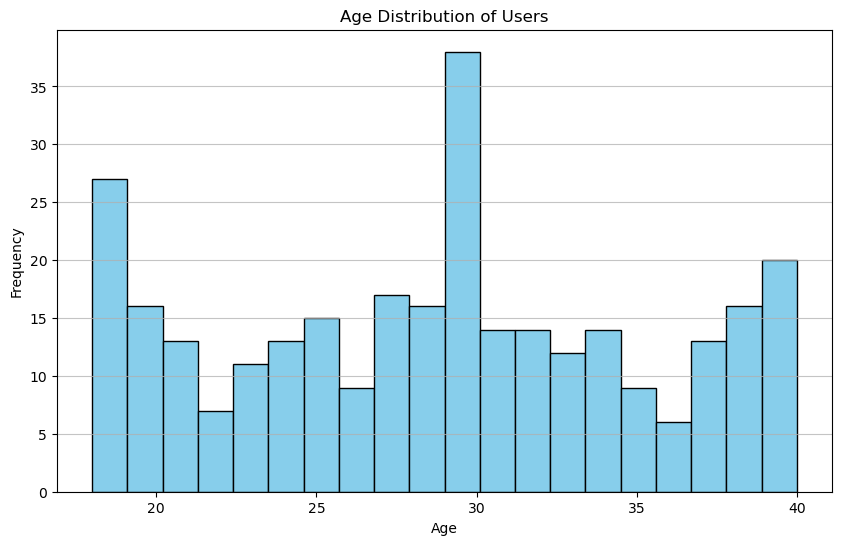

In [ ]:
# Plot age distribution

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(users_df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


<Axes: xlabel='Age'>

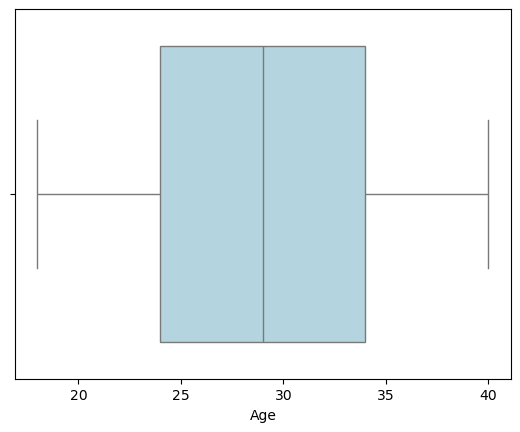

In [39]:
import seaborn as sns

sns.boxplot(x=users_df['Age'], color='lightblue')

We can see that there are no outliers and that the distribution is not normal, with a peak at 30 years old.

The describe function also showed that the youngest user is 18 years old and the oldest is 40 years old

In [42]:
# Plot location distribution
plt.figure(figsize=(12, 6))
sns.heatmap(users_df['Location'].value_counts().reset_index().rename(columns={'index': 'Location', 'Location': 'Count'}).set_index('Location').T, annot=True, fmt='d', cmap='Blues')
plt.title('Location Distribution of Users')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


KeyError: "None of ['Location'] are in the columns"

<Figure size 1200x600 with 0 Axes>